In [3]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  26.4M      0  0:00:28  0:00:28 --:--:-- 29.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9996k      0  0:00:01  0:00:01 --:--:-- 9996k


In [4]:
import os
from IPython.display import Image,display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import random

from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

In [5]:


input_dir="images/"
target_dir="annotations/trimaps/"

img_size=(160,160)
num_classes=4

input_img_paths=sorted([os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths=sorted([os.path.join(target_dir,fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Numbert of samples: ",len(input_img_paths))



Numbert of samples:  7390


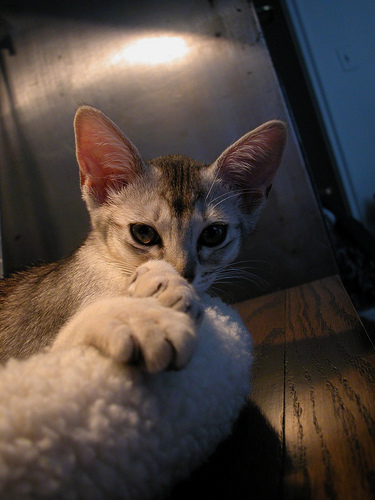

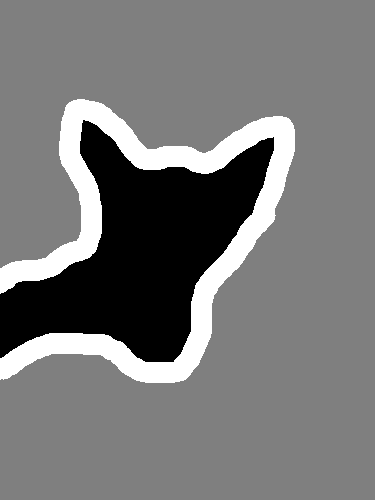

In [6]:
display(Image(filename=input_img_paths[1]))

img=PIL.ImageOps.autocontrast(load_img(target_img_paths[1]))
display(img)

In [7]:
class OxfordPets(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
    self.batch_size=batch_size
    self.img_size=img_size
    self.input_img_paths=input_img_paths
    self.target_img_paths=target_img_paths

  def __len__(self):
    return len(self.target_img_paths) //self.batch_size
  def __getitem__(self,idx):
    i=idx*self.batch_size
    batch_input_img_paths=self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths=self.target_img_paths[i:i+self.batch_size]
    x=np.zeros((batch_size,)+self.img_size+(3,),dtype="float32")
    for j,path in enumerate(batch_input_img_paths):
      img=load_img(path,target_size=self.img_size)
      x[j]=img
    y=np.zeros((batch_size,) +self.img_size +(1,),dtype="uint8")
    for j,path in enumerate(batch_target_img_paths):
      img=load_img(path,target_size=self.img_size,color_mode="grayscale")
      y[j]=np.expand_dims(img,2)
    return x,y

In [9]:
def get_model(img_size,num_classes):
  inputs=keras.Input(shape=img_size+(3,))

  #Entry Block
  x=layers.Conv2D(32,3,strides=2,padding='same')(inputs)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  previous_block_activation=x # Set aside residual

  # Block 1 ,2 3
  # f=filters
  for f in[64,128,256]:
    x=layers.Activation('relu')(x)
    x=layers.SeparableConv2D(f,3,padding='same')(x)
    x=layers.BatchNormalization()(x)

    x=layers.Activation("relu")(x)
    x=layers.SeparableConvolution2D(f,3,padding='same')(x)
    x=layers.BatchNormalization()(x)

    x=layers.MaxPooling2D(3,strides=2,padding='same')(x)

    #project residual

    residual=layers.Conv2D(f,1,strides=2,padding='same')(previous_block_activation)

    x=layers.add([x,residual])
    previous_block_activation=x
  
  for f in [256,128,64,32]:
    x=layers.Activation('relu')(x)
    x=layers.Conv2DTranspose(f,3,padding='same')(x)
    x=layers.BatchNormalization()(x)

    x=layers.Activation("relu")(x)
    x=layers.Conv2DTranspose(f,3,padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.UpSampling2D(2)(x)

    #project residual

    residual=layers.UpSampling2D(2)(previous_block_activation)
    residual=layers.Conv2D(f,1,padding='same')(residual)

    x=layers.add([x,residual])
    previous_block_activation=x
  outputs=layers.Conv2D(num_classes,3,activation="softmax",padding='same')(x)

  model=keras.Model(inputs,outputs)

  return model

keras.backend.clear_session()

model=get_model(img_size,num_classes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
batch_size=32
val_samples=500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths=input_img_paths[:-val_samples]
train_target_img_paths=target_img_paths[:-val_samples]

val_input_img_paths=input_img_paths[-val_samples:]
val_target_img_paths=target_img_paths[-val_samples:]

train_gen=OxfordPets(batch_size,img_size,train_input_img_paths,train_target_img_paths)
val_gen=OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)


In [ ]:
model.compile(optimizer="SGD",loss="sparse_categorical_crossentropy") #Adam vb optimizer ve loss değişebilir.

callbacks=[keras.callbacks.ModelCheckpoint("oxford_segmentatioın.h5", save_best_only=True)]

epochs=25
model.fit(train_gen,epochs=epochs,validation_data=val_gen,callbacks=callbacks)
#Kaldığı yerden tekrar eğitime başlatıyorum.

Epoch 1/25
215/215 [==============================] - 85s 383ms/step - loss: 0.4136 - val_loss: 0.5240
Epoch 2/25


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


215/215 [==============================] - 81s 378ms/step - loss: 0.4093 - val_loss: 0.4862
Epoch 3/25
215/215 [==============================] - 81s 378ms/step - loss: 0.4047 - val_loss: 0.4713
Epoch 4/25
215/215 [==============================] - 81s 378ms/step - loss: 0.4017 - val_loss: 0.4612
Epoch 5/25
215/215 [==============================] - 81s 378ms/step - loss: 0.3981 - val_loss: 0.4979
Epoch 6/25
215/215 [==============================] - 81s 378ms/step - loss: 0.3934 - val_loss: 0.4680
Epoch 7/25
215/215 [==============================] - 81s 377ms/step - loss: 0.3900 - val_loss: 0.4642
Epoch 8/25
215/215 [==============================] - 81s 378ms/step - loss: 0.3855 - val_loss: 0.4960
Epoch 9/25
215/215 [==============================] - 81s 378ms/step - loss: 0.3813 - val_loss: 0.4931
Epoch 10/25
215/215 [==============================] - 82s 379ms/step - loss: 0.3791 - val_loss: 0.4989
Epoch 11/25
215/215 [==============================] - 82s 379ms/step - loss: 0.375

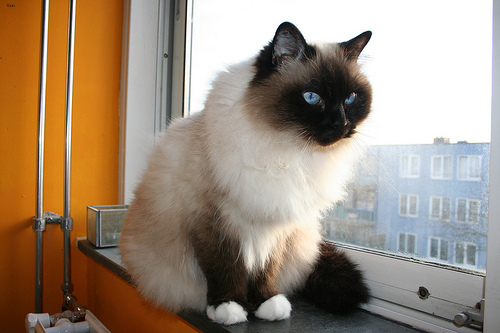

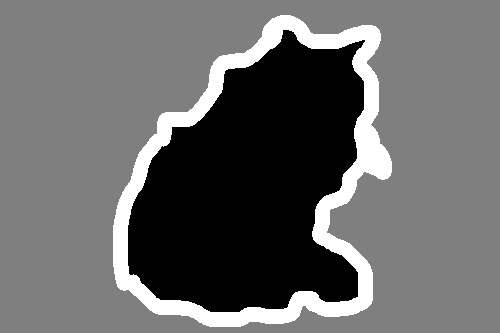

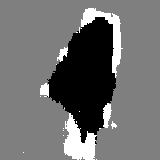

In [17]:
val_gen=OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)
model=keras.models.load_model("oxford_segmentatioın.h5")
val_preds=model.predict(val_gen)
def display_mask(i):
  mask=np.argmax(val_preds[i],axis=-1)
  mask=np.expand_dims(mask,axis=-1)
  img=PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)
i=245

display(Image(filename=val_input_img_paths[i]))
img=PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)

